In [73]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.feature # Might not need this.

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import tensorflow.keras as keras
import tensorflow as tf
print(tf.__version__)

1.13.1


In [139]:
# Load in data
trainImages = np.load('trnImage.npy')
trainLabels = np.load('trnLabel.npy')

testImages = np.load('tstImage.npy')
testLabels = np.load('tstLabel.npy')

print(trainLabels.shape)

(10000, 1)


In [42]:
def computeFeatures(image):
    # This function computes the HOG features with the parsed hyperparameters and returns the features as hog_feature. 
    # By setting visualize=True we obtain an image, hog_as_image, which can be plotted for insight into extracted HOG features.
    hog_feature, hog_as_image = skimage.feature.hog(image, visualize=True, block_norm='L2-Hys')
    return hog_feature, hog_as_image

In [147]:
my_array = np.zeros((324, 10000))
labels_array = np.zeros(10000,)

for i in range(10000):
    features, hog_image = computeFeatures(trainImages[:,:,:,i])
    my_array[:, i] = features
    
for i in range(10000):
    labels_array = trainLabels[i]

print(my_array.shape)
print(my_array)
print(labels_array.shape)
print(labels_array)

(324, 10000)
[[0.00635811 0.01920765 0.01217736 ... 0.04490437 0.21252506 0.02293872]
 [0.00839428 0.00473263 0.0054246  ... 0.00851013 0.00502404 0.02055349]
 [0.04832912 0.01761932 0.00613002 ... 0.00601955 0.0028512  0.00089031]
 ...
 [0.01382991 0.25589432 0.05638422 ... 0.03078654 0.05064608 0.02484317]
 [0.09835105 0.08250159 0.00461683 ... 0.01877822 0.04379965 0.00299953]
 [0.16365765 0.03275345 0.21952726 ... 0.07656842 0.1453032  0.00714693]]
(1,)
[10]


In [105]:
type(features)

numpy.ndarray

In [161]:
LDA = LinearDiscriminantAnalysis(n_components=2)

print(my_array.shape)
print(features.shape)
print(labels_array)

LDA.fit(my_array, features)

x = LDA.transform(my_array)

plt.scatter(x[:, 0], x[:, 1], c=features)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Comparison')
plt.show()

(324, 10000)
(324,)
[10]


ValueError: Unknown label type: (array([0.02293872, 0.02055349, 0.00089031, 0.00440294, 0.08704109,
       0.00300701, 0.00029677, 0.00093847, 0.01338334, 0.11294568,
       0.14716456, 0.11823831, 0.12222102, 0.24016815, 0.15754109,
       0.06220387, 0.08763762, 0.21097857, 0.03516555, 0.        ,
       0.03876096, 0.09743463, 0.22545705, 0.25394949, 0.07758316,
       0.0033837 , 0.        , 0.08832151, 0.06506014, 0.10459548,
       0.05325892, 0.25394949, 0.15225854, 0.0302929 , 0.05473851,
       0.10610456, 0.25394949, 0.13056355, 0.10470136, 0.04543583,
       0.0859256 , 0.11244519, 0.0344907 , 0.145456  , 0.25394949,
       0.02296039, 0.00206677, 0.04408558, 0.13665174, 0.25394949,
       0.15102315, 0.06205355, 0.02995883, 0.05191187, 0.03994841,
       0.01224709, 0.03685882, 0.03797795, 0.12886496, 0.02737331,
       0.06185343, 0.04533615, 0.05699345, 0.18365342, 0.16592744,
       0.05817343, 0.06832259, 0.03675481, 0.02222411, 0.10743472,
       0.12119881, 0.2086273 , 0.05065414, 0.02637371, 0.02946652,
       0.0431788 , 0.16888525, 0.02276751, 0.02793569, 0.03856826,
       0.02377369, 0.10238216, 0.13340064, 0.10717979, 0.11079   ,
       0.21770584, 0.14280668, 0.0563861 , 0.0794411 , 0.19124629,
       0.0318766 , 0.        , 0.03513574, 0.08832182, 0.20437063,
       0.24156143, 0.07032701, 0.00306723, 0.        , 0.0119945 ,
       0.        , 0.00255917, 0.04122444, 0.06489464, 0.05760237,
       0.08812705, 0.07893667, 0.06148171, 0.23372525, 0.11835227,
       0.09490891, 0.04118633, 0.0778892 , 0.10192848, 0.03126488,
       0.13185187, 0.24156143, 0.02081296, 0.00187347, 0.03996237,
       0.12387106, 0.24156143, 0.13689834, 0.05624984, 0.02715686,
       0.04705668, 0.12202782, 0.03672579, 0.24019843, 0.14978963,
       0.17082373, 0.12412062, 0.03449189, 0.07657979, 0.05197464,
       0.16647679, 0.15040867, 0.05273262, 0.06193256, 0.03331722,
       0.02014555, 0.09738663, 0.1098634 , 0.18911493, 0.04591659,
       0.02390705, 0.02671059, 0.0391404 , 0.15308985, 0.02063813,
       0.02532293, 0.03496107, 0.0215502 , 0.1093029 , 0.04553132,
       0.01454852, 0.07697317, 0.17905932, 0.24156143, 0.06553954,
       0.05144701, 0.05996544, 0.11695338, 0.08615119, 0.13850301,
       0.07052428, 0.25777449, 0.20161738, 0.04011319, 0.07248351,
       0.1405013 , 0.25777449, 0.17288935, 0.13864322, 0.06016511,
       0.11378078, 0.14889743, 0.04567183, 0.19260961, 0.25777449,
       0.03040364, 0.00273677, 0.05837715, 0.18095121, 0.25777449,
       0.1999815 , 0.08216993, 0.03967082, 0.06874054, 0.0528988 ,
       0.01621732, 0.04880764, 0.05028956, 0.17064012, 0.03624713,
       0.08190494, 0.06003313, 0.07546947, 0.24318978, 0.21971744,
       0.07703197, 0.09047126, 0.0486699 , 0.02942868, 0.14226268,
       0.16048878, 0.25777449, 0.06707508, 0.03492349, 0.03901891,
       0.05717641, 0.22363411, 0.03014824, 0.03699182, 0.05107123,
       0.03148059, 0.04669325, 0.02945326, 0.0165336 , 0.03053833,
       0.0771438 , 0.00823648, 0.01758734, 0.01318593, 0.01916129,
       0.02144168, 0.04914832, 0.02178676, 0.06620308, 0.09113325,
       0.0382067 , 0.02372996, 0.04275377, 0.00870335, 0.04452408,
       0.01744662, 0.01164256, 0.04092229, 0.09729907, 0.0366274 ,
       0.00648838, 0.00710251, 0.02068813, 0.24323111, 0.15254546,
       0.12232906, 0.05308548, 0.10039219, 0.13137667, 0.04029762,
       0.16994523, 0.24323111, 0.02682604, 0.00241473, 0.05150791,
       0.15965868, 0.24323111, 0.17644967, 0.07250099, 0.03500275,
       0.06065184, 0.1572829 , 0.04733624, 0.24323111, 0.19306539,
       0.22017645, 0.15998033, 0.04445695, 0.09870447, 0.06699065,
       0.21457363, 0.19386328, 0.06796761, 0.07982551, 0.04294291,
       0.0259658 , 0.12552262, 0.14160406, 0.24323111, 0.05918236,
       0.03081404, 0.03442756, 0.05044846, 0.19731907, 0.02660069,
       0.03263899, 0.04506168, 0.02777627, 0.14088162, 0.05868578,
       0.01875173, 0.09921151, 0.23079139, 0.24323111, 0.08447459,
       0.06631057, 0.07729007, 0.01891863, 0.04336504, 0.01922311,
       0.05841296, 0.0804096 , 0.03371092, 0.02093765, 0.03772294,
       0.00767922, 0.03928493, 0.01539368, 0.01027258, 0.03610696,
       0.08584988, 0.03231746, 0.0057249 , 0.00626676, 0.01825375,
       0.02861669, 0.01903815, 0.01142415, 0.02464893, 0.04007305,
       0.02817007, 0.02484317, 0.00299953, 0.00714693]),)

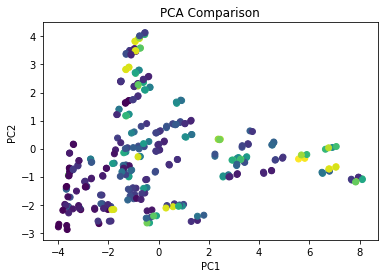

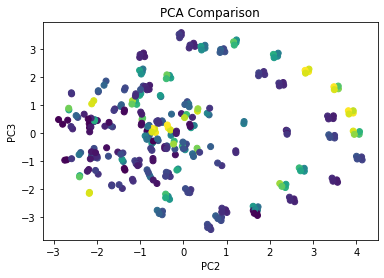

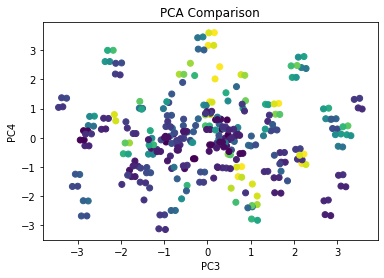

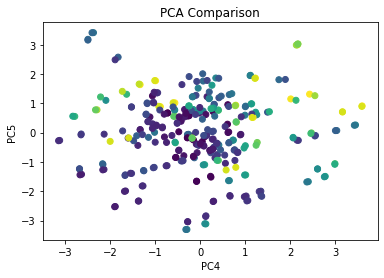

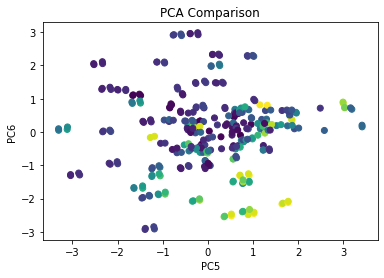

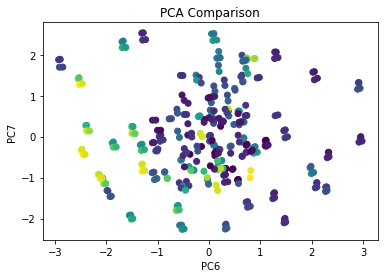

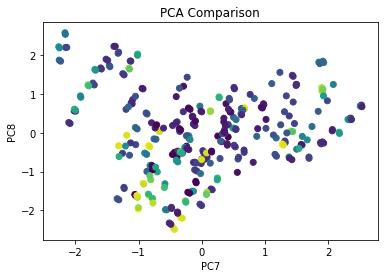

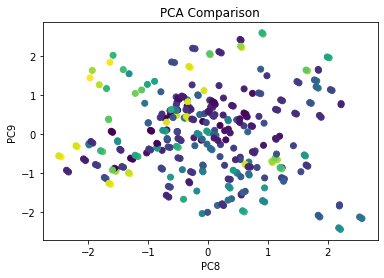

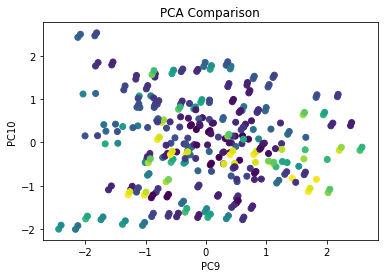

In [103]:
pca = PCA(n_components=10)

pca.fit(my_array)

x = pca.transform(my_array)

for i in range(9):
    plt.scatter(x[:, i], x[:, i+1], c=features)
    plt.xlabel('PC'+ str(i+1))
    plt.ylabel('PC'+ str(i+2))
    plt.title('PCA Comparison')
    plt.show()

In [60]:
# Training the Neural Net

number_of_classes = np.max(features)

# Build our network architecture by stacking layers in a Keras Sequential object.
model = keras.Sequential()

# Create the input layer, this takes an argument of the input data shape (i.e. number of features)
model.add(keras.layers.InputLayer(input_shape=(trainImages.shape[1],)))

# Create hidden layers
model.add(keras.layers.Dense(10, activation='sigmoid')) # first layer
model.add(keras.layers.Dense(10, activation='sigmoid')) # second layer

# Create output layer to get predicted class labels.
model.add(keras.layers.Dense(number_of_classes, activation='softmax'))

# Generate a callable keras Model object which contains our architecture.
# This allows us to train and predict our neural network on the datasets.
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['acc'])

# Fit our model to the data
history = model.fit(trainImages, features, validation_data=(testImages, features), epochs=1000, verbose=0)

# Predict probabilities of classes for the testing set.
predicted_probabilities = model.predict(testImages)

# Use argmax to get the predicted class label
predicted_labels = np.argmax(predicted_probabilities, axis=1)

# Calculate the percentage accuracy rate on test set
accuracy = np.sum(np.equal(testLabels, predicted_labels)) / testLabels.shape[0] * 100
print('Percentage accuracy on testing set is: {0:.2f}%'.format(accuracy))

ValueError: Error when checking input: expected input_7 to have 2 dimensions, but got array with shape (32, 32, 3, 10000)

In [ ]:
# Plot the training curves for model accuracy
plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('Accuracy %')
plt.xlabel('Epoch')

# Plot the training curves for the model's loss
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()